In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from monpa import utils
from collections import Counter
import jieba
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pickle
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, LSTM
pd.options.mode.chained_assignment = None

file_names = ["./data/bda2024_202203-202402_內容數據_新聞1.csv",
              "./data/bda2024_202203-202402_討論數據_dcard.csv",
              "./data/bda2024_202203-202402_討論數據_mobile01-1.csv",
              "./data/bda2024_202203-202402_討論數據_mobile01-2.csv",
              "./data/bda2024_202203-202402_討論數據_ptt.csv",
              "./data/bda2024_202203-202402_內容數據_新聞2.csv",
              "./data/bda2024_202203-202402_內容數據_新聞3.csv"]

+---------------------------------------------------------------------+
  Welcome to MONPA: Multi-Objective NER POS Annotator for Chinese
+---------------------------------------------------------------------+
已找到 model檔。Found model file.


04/20/2024 23:39:52 - WARNING - tensorflow - From C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\losses.py:2976: The name tf.losses.sparse_softmax_cross_entropy is deprecated. Please use tf.compat.v1.losses.sparse_softmax_cross_entropy instead.



### Data Preprocessing

- **將有缺失值的文章刪掉**
- **將日期一律轉換成 年/月/日 的形式**
- **n 表示 預測n天後的股價**

In [2]:
stock_name = "競國"
stock_symbol = "6108"
def preprocessing(stock_name, stock_symbol, n):
    df = pd.concat([pd.read_csv(file_name) for file_name in file_names], axis=0)[["post_time", "content", "title"]]
    df["text"] = df["title"].str.strip() + " " + df["content"].str.strip()
    df.dropna(subset=["text"], inplace=True)
    df = df[df['text'].str.contains(f'{stock_name}|{stock_symbol}')][['post_time', 'text']]
    df['text'] = df['text'].str.replace(r'\d+', '', regex=True)
    df["post_time"] = pd.to_datetime(df['post_time'])
    stock_df = pd.read_csv("./data/bda2024_微股力_個股交易數據-2年.csv")
    stock_df = stock_df[stock_df['stock_symbol'].astype(str).str.contains(stock_symbol)]
    stock_df['date'] = pd.to_datetime(stock_df['date'])
    stock_df["next_close"] = stock_df["close"].shift(-n)
    stock_df.dropna(subset=["next_close"], inplace=True)
    return df.sort_values(by="post_time"), stock_df.sort_values(by="date")

### Merge Data and Label Tagging(stock file and another files)

- **delta 表示 當漲delta2以上 為看漲文章 label為1；跌delta1以上 為看跌文章 label為0**

In [3]:
def merge(df, df2, delta1, delta2):
    merged_df = pd.merge_asof(df, df2, left_on='post_time', right_on='date', direction='backward')
    condition1 = (merged_df['next_close'] - merged_df["close"]) / merged_df["close"] <= -delta1  # 跌幅大於 -delta
    condition2 = (merged_df['next_close'] - merged_df["close"]) / merged_df["close"] >= delta2  # 漲幅大於等於 delta
    merged_df['label'] = np.select([condition1, condition2], [0, 1], default=2)
    merged_df = merged_df[~(merged_df["label"] == 2)]
    return merged_df[["date", "text", "label"]]

In [4]:
def after_merge_data(stock_name, stock_symbol, n=1, delta1=0, delta2=0.01):
    df, stock_df = preprocessing(stock_name, stock_symbol, n)
    merged_df = merge(df, stock_df, delta1, delta2)
    return merged_df

### Get vocabulary of dataset

- 本次報告採用jieba進行切詞，因為ckipTagger, monpa切詞的時間長
- 在斷詞過後，取得長度大於1 及 長度小於7 的字當作關鍵字

In [5]:
def get_vocabulary(df):
    tf_counter = Counter() #預備統計tf用
    df_down = df[df["label"] == 0]
    for i, text in enumerate(df["text"]):
        sentence_list = utils.short_sentence(text) #斷句
        temp = []
        for item in sentence_list:
            result_cut = jieba.cut(item) #斷詞
            for term in result_cut:
                term = term.strip() #去除前後多餘空白
                if(len(term) > 1 and len(term) <= 6):
                    tf_counter[term] += 1 #tf加1
                    temp.append(term)
        df["text"].iloc[i] = " ".join(temp)

    # tf_counter = Counter() #預備統計tf用
    # df_up = df[df["label"] == 2]
    # for text in df_up["text"]: #對內容逐行列舉，row[0]是title, row[1]是content             
    #     sentence_list = utils.short_sentence(text) #斷句
    #     for item in sentence_list:
    #         result_cut = jieba.cut(item) #斷詞
    #         for term in result_cut:
    #             term = term.strip() #去除前後多餘空白
    #             if(len(term) > 1 and len(term) <= 6):
    #                 tf_counter[term] += 1 # tf加1
    # for term in tf_counter.most_common(200):
    #     if term[0] not in termset:
    #         termset[term[0]] = no
    #         no += 1
        
    for text in df_down["text"]: #對內容逐行列舉，row[0]是title, row[1]是content
        sentence_list = utils.short_sentence(text) #斷句
        for item in sentence_list:
            result_cut = jieba.cut(item) #斷詞
            for term in result_cut:
                term = term.strip() #去除前後多餘空白
                if(len(term) > 1 and len(term) <= 6):
                    tf_counter[term] += 1 #tf加1
    termset = {}
    no = 0
    for term in tf_counter.most_common(200):
        if term[0] not in termset:
            termset[term[0]] = no
            no += 1

    tf_counter = Counter() #預備統計tf用
    df_t = df[df["label"] == 1]
    for text in df_t["text"]: #對內容逐行列舉，row[0]是title, row[1]是content             
        sentence_list = utils.short_sentence(text) #斷句
        for item in sentence_list:
            result_cut = jieba.cut(item) #斷詞
            for term in result_cut:
                term = term.strip() #去除前後多餘空白
                if(len(term) > 1 and len(term) <= 6):
                    tf_counter[term] += 1 # tf加1
    for term in tf_counter.most_common(200):
        if term[0] not in termset:
            termset[term[0]] = no
            no += 1
    return df, termset

### Use vocabulary to get vector space

- **利用tfidf來作為建立向量空間的指標**

In [6]:
with open("停用詞-繁體中文.txt", mode="r", encoding="utf-8") as reader:
    stop_words = [i.strip() for i in reader.readlines()]
def get_X_y(df, vocabulary):
    vectorizer = TfidfVectorizer(min_df=3, vocabulary=vocabulary, stop_words=stop_words, use_idf=True) #用給定的termset建構向量，並使用idf加權
    X = vectorizer.fit_transform(df["text"]).toarray() #用給定的文件集做計算
    return X, df["label"]

#### Build NN model

In [7]:
def build_model(shape):
    inputs = layers.Input(shape=shape)
    x = layers.Dense(32, activation="relu")(inputs)
    x = layers.LayerNormalization()(x)
    x = layers.Dense(16, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.01),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    return model

In [208]:
n = 3
delta1 = 0.03
delta2 = 0.03
merged_df = after_merge_data(stock_name, stock_symbol, n, delta1, delta2)
print(merged_df['label'].value_counts()) # 看label的分布情況

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_1756\976656221.py:10: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  stock_df = pd.read_csv("./data/bda2024_微股力_個股交易數據-2年.csv")


label
0    38
1    22
Name: count, dtype: int64


In [209]:
merged_df, vocabulary = get_vocabulary(merged_df)
pd.DataFrame(vocabulary.keys()).to_csv(f"./keywords/{stock_name}_關鍵字列表.csv")
merged_df

,date,text,label
16,2022-04-21,請益 現在 可以 金融股 https www dcard tw money cid BED ...,0
27,2022-06-28,公告 尚立 調整 現金 股利 配息率 月日 公司 名稱 尚立 調整 現金 股利 配息率 發言...,0
28,2022-07-11,公告 競國 年月 合併 營收 年增 .% 日期 上市 公司 競國 單位,0
95,2023-06-26,公告 競國 子公司 競陸 電子 昆山 有限 公司 累積 同一 相對 取得 處分 人民幣 保本...,1
122,2023-08-15,新南 陳正祺 上半年 新南 投資 超越 中國 協助 台商 深入 了解 亞太 產業 趨勢 深化...,1
123,2023-08-21,盤中 解析 AI 台積 多空 PK 保衛戰 開打 時報 記者 張漢綺 台北 報導 美股 尾盤...,0
124,2023-08-21,公告 修正 競國 年度 股東會 年報 部份 內容 英文版 月日 公司 名稱 競國 修正 競國...,0
125,2023-08-21,盤後 解析 台股 微紅漲 後市 錦囊 時報 記者 張漢綺 台北 報導 利空 陰霾 難除 台股...,0
126,2023-08-21,公告 競國 召開 法人 說明會 相關 資訊 月日 公司 名稱 競國 競國 召開 法人 說明會...,0
127,2023-08-22,台股 收盤 指數 大盤 收盤 統計 加權 指數 .% 櫃買 指數 .% 台股 成交 金額 今...,0


In [210]:
X, y = get_X_y(merged_df, vocabulary)
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=56)

C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_extraction\text.py:1381: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


### 使用不同的model對於總體資料做訓練，在這使用了
- NN
- Naive Bayes
- Decision Tree
- KNN
- SVM
- RandomForest

NN:
1/1 [==============================] - 0s 110ms/step


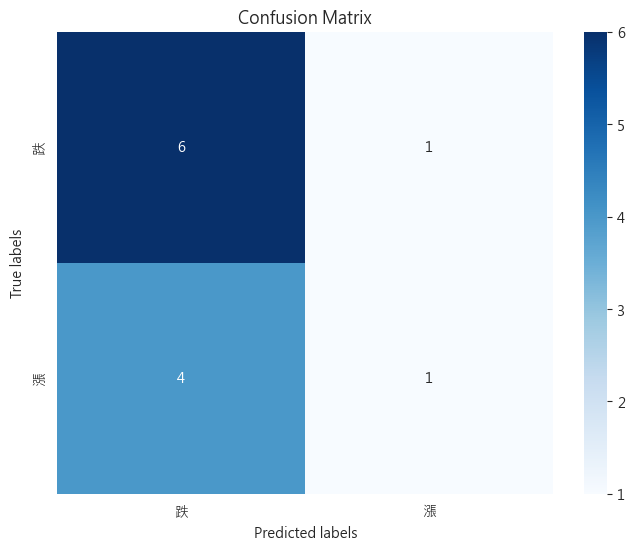

Accuracy: 58.330000000000005%

MultinomialNB


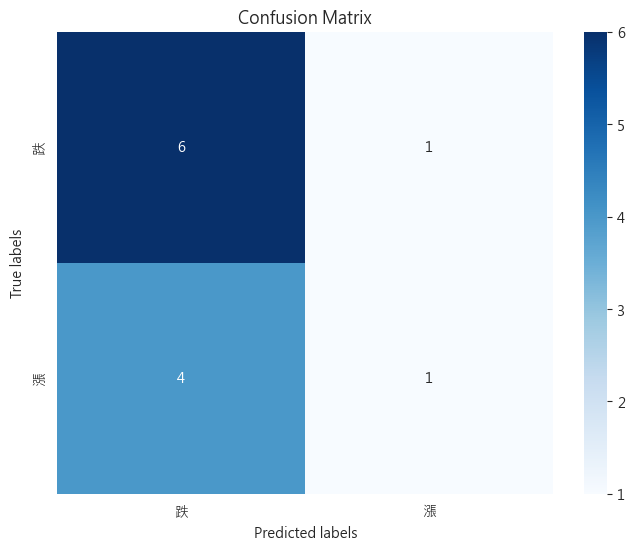

Accuracy: 58.330000000000005%

DecisionTreeClassifier


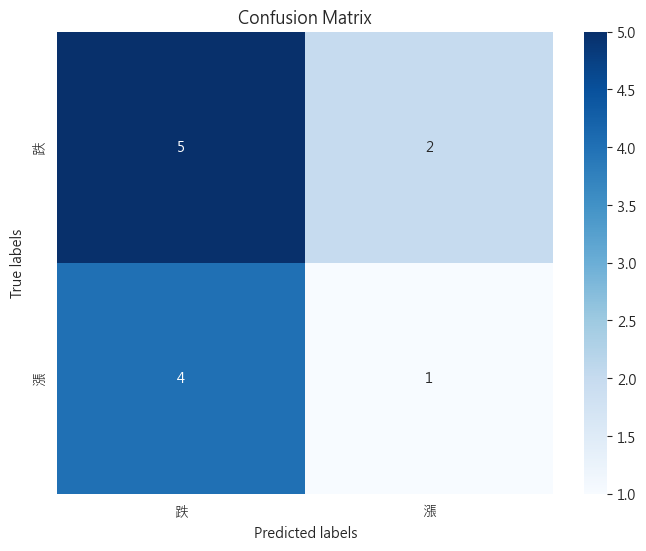

Accuracy: 50.0%

KNeighborsClassifier


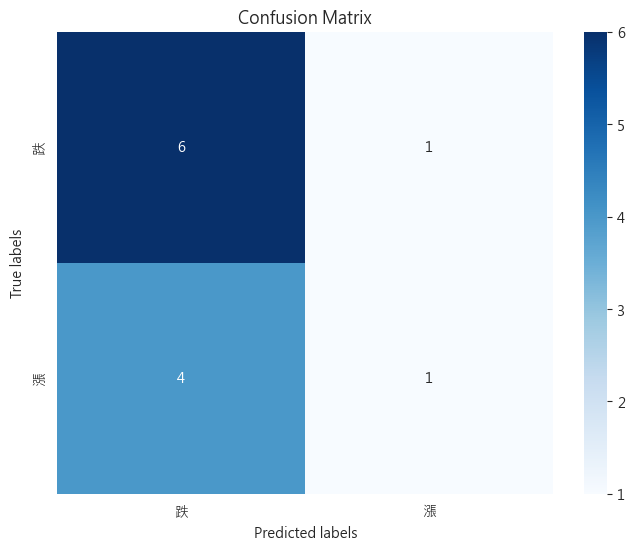

Accuracy: 58.330000000000005%

SVC


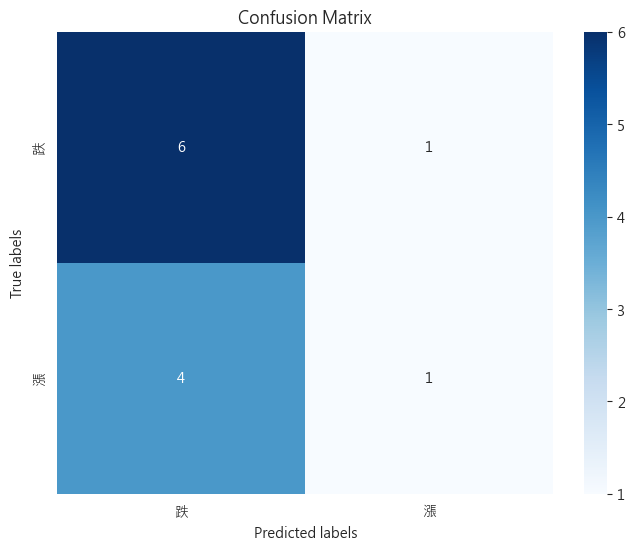

Accuracy: 58.330000000000005%

RandomForestClassifier


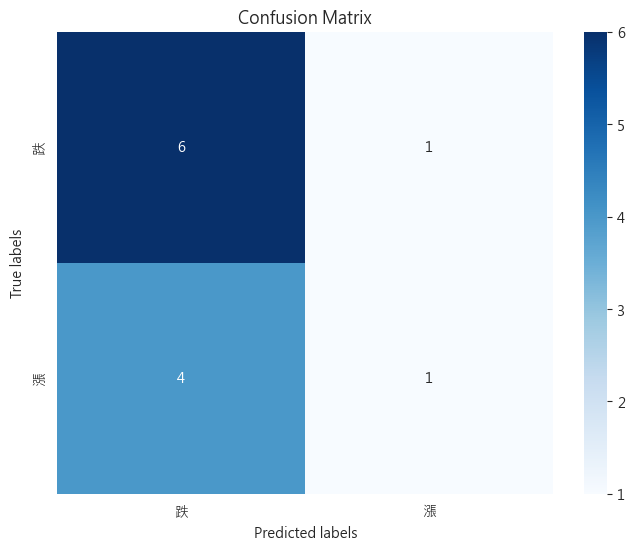

Accuracy: 58.330000000000005%



In [211]:
NN_model = build_model((X.shape[1],))
callbacks = [
keras.callbacks.ModelCheckpoint(f"./models/{stock_name}_overall.keras", save_best_only=True)
]

classifier1 = MultinomialNB()
classifier2 = DecisionTreeClassifier()
classifier3 = KNeighborsClassifier(n_neighbors=7)
classifier4 = SVC()
classifier5 = RandomForestClassifier(n_estimators=200)
for model in ["NN", classifier1, classifier2, classifier3, classifier4, classifier5]:
    if model == "NN":
        print("NN:")
        history = NN_model.fit(train_X, train_y, epochs=100, batch_size=2, validation_data=(test_X, test_y), callbacks=callbacks, verbose=0)
        _, acc = NN_model.evaluate(test_X, test_y)
        show_confusion_matrix(test_y, (NN_model.predict(test_X) > 0.5).astype(int))
        print(f"Accuracy: {round(acc, 4) * 100}%\n")
    else:
        print(f"{type(model).__name__}")
        model.fit(train_X, train_y)
        with open(f"./models/{stock_name}_{type(model).__name__}.pkl", 'wb') as file: pickle.dump(model, file)
        show_confusion_matrix(test_y, model.predict(test_X))
        print(f"Accuracy: {round(accuracy_score(test_y, model.predict(test_X)), 4) * 100}%\n")
        

- **回測**

In [9]:
def curation(df, start_period, end_period):
    df = df[(pd.to_datetime(df["date"]) < end_period) & (pd.to_datetime(df["date"]) >= start_period)]
    return df[["date", "text", "label"]]

##### Just a util !

In [8]:
def get_date_interval():
    tem = []
    temp2 = 2022
    while True:
        for j in range(1, 13):
            if j in [7, 8, 9]:
                tem.append((f"{temp2}-0{j}-01", f"{temp2}-{j + 3}-01"))
            elif j not in [10, 11, 12]:
                tem.append((f"{temp2}-0{j}-01", f"{temp2}-0{j + 3}-01"))
            elif j == 10:
                tem.append((f"{temp2}-{j}-01", f"{temp2 + 1}-0{(j + 3) % 12}-01"))
                temp2 += 1
            else:
                temp2 -= 1
                tem.append((f"{temp2}-{j}-01", f"{temp2 + 1}-0{(j + 3) % 12}-01"))
                temp2 += 1
        if temp2 == 2025:
            break
    return tem[2:-12]
date_interval = get_date_interval()

#### For every date_interval of data constructing vocabulary and build model!

In [50]:
train_dataset = []
test_dataset = []
# date_interval = get_date_interval()
for i in range(len(date_interval) - 1):
    train_dataset.append(curation(merged_df, date_interval[i][0], date_interval[i][1]))
    test_dataset.append(curation(merged_df, date_interval[i][1], date_interval[i + 1][1]))

NameError: name 'merged_df' is not defined

- 利用準確率最高的NN做回測

In [215]:
history_test = []
pred_y_history = []
y_history = []
accuracy_array = []
take_array = []
conf_matrix = np.array([[0, 0], [0, 0]])
for i in range(len(train_dataset)):
    try:
        train_dataset[i], temp_vocabulary = get_vocabulary(train_dataset[i])
        pd.DataFrame(temp_vocabulary.keys()).to_csv(f"./keywords/{stock_name}_關鍵字列表_{i + 1}.csv")
        temp_X, temp_y = get_X_y(train_dataset[i], temp_vocabulary)
        temp_X_test, temp_y_test = get_X_y(test_dataset[i], temp_vocabulary)
        y_history.append(temp_y_test)
        temp_model = build_model((temp_X.shape[1],)) ## NN的方式
        # temp_model = MultinomialNB()
        history_test.append(temp_model.fit(temp_X, temp_y))
        # with open(f'./models/{stock_name}_{type(temp_model).__name__}_{i}.pkl', 'wb') as file: pickle.dump(temp_model, file)
        y_pred = temp_model.predict(temp_X_test)
        y_pred = (y_pred > 0.5).astype(int) # 用NN的方式需要這樣做!! 否則註解掉
        test_dataset[i]["pred"] = y_pred
        counts = test_dataset[i].groupby(["date", "pred"]).size().unstack(fill_value=0)
        counts["pred"] = counts.apply(lambda x: 1 if x.get(1, 0) > (x.get(0, 0) + 5) else (0 if x.get(0, 0) > x.get(1, 0 + 5) else "不買"), axis=1)
        results = counts.merge(test_dataset[i][["date", "label"]].drop_duplicates(), on="date")
        print(results)
        accuracy_array.append((results.pred == results.label).mean())
        take_array.append(((results['pred'] == 1) | (results['pred'] == 0)).mean())
        print(f"準確率: {(results.pred == results.label).mean()}")
        print(f"出手率: {((results['pred'] == 1) | (results['pred'] == 0)).mean()}")
        filtered_results = results[(results['pred'] == 1) | (results['pred'] == 0)]
        conf_matrix += confusion_matrix(filtered_results['label'], filtered_results['pred'])
    except:
        print("")

C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_extraction\text.py:1381: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


1/1 [==============================] - 0s 159ms/step
        date  0 pred  label
0 2022-06-28  1   不買      0
準確率: 0.0
出手率: 0.0



C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_extraction\text.py:1381: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


1/1 [==============================] - 0s 100ms/step
        date  1 pred  label
0 2022-07-11  1   不買      0
準確率: 0.0
出手率: 0.0













1/1 [==============================] - 0s 138ms/step
        date  0  1 pred  label
0 2023-08-15  1  0    0      1
1 2023-08-21  2  2   不買      0
2 2023-08-22  1  0    0      0
3 2023-08-25  0  1   不買      0
準確率: 0.25
出手率: 0.5



C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_extraction\text.py:1381: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


1/1 [==============================] - 0s 108ms/step
        date  0  1 pred  label
0 2023-09-18  4  0    0      1
1 2023-09-19  1  0    0      1
2 2023-09-21  2  1    0      1
3 2023-09-22  1  1   不買      1
4 2023-09-25  4  3    0      0
5 2023-09-26  5  0    0      1
準確率: 0.16666666666666666
出手率: 0.8333333333333334



C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_extraction\text.py:1381: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


1/1 [==============================] - 0s 103ms/step
        date  0  1 pred  label
0 2023-10-05  0  1   不買      0
1 2023-10-06  2  0    0      0
準確率: 0.5
出手率: 0.5



C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_extraction\text.py:1381: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


1/1 [==============================] - 0s 116ms/step
        date  0 pred  label
0 2023-11-10  2   不買      1
1 2023-11-21  1   不買      0
準確率: 0.0
出手率: 0.0



C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_extraction\text.py:1381: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


1/1 [==============================] - 0s 107ms/step
        date  0  1  pred  label
0 2023-12-08  4  2     0      0
準確率: 1.0
出手率: 1.0


C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_extraction\text.py:1381: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


1/1 [==============================] - 0s 109ms/step
        date  0 pred  label
0 2024-01-02  4   不買      0
1 2024-01-03  3   不買      0
2 2024-01-09  2   不買      0
3 2024-01-10  2   不買      0
4 2024-01-23  1   不買      1
準確率: 0.0
出手率: 0.0



C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_extraction\text.py:1381: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


1/1 [==============================] - 0s 117ms/step
        date  0 pred  label
0 2024-02-05  2   不買      1
1 2024-02-19  1   不買      0
準確率: 0.0
出手率: 0.0



#### 看每一個回測期間accuracy的變化

Average test accuracy:  21.30%


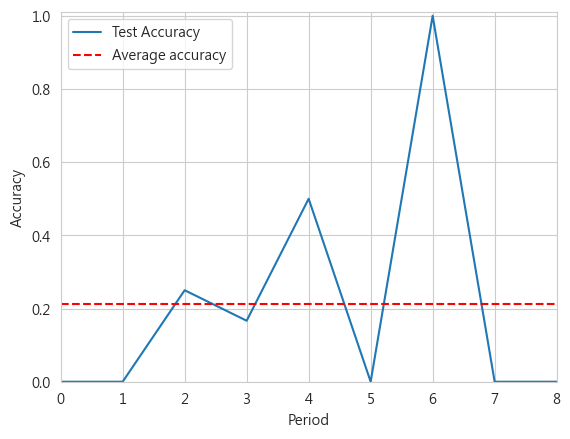

In [216]:
print(f"Average test accuracy:  {100 * np.mean(accuracy_array):.2f}%")
epoch = range(len(history_test))
plt.figure()
plt.xlabel('Period')
plt.ylabel('Accuracy')
plt.plot(epoch, accuracy_array, label='Test Accuracy')
plt.plot(epoch, [np.mean(accuracy_array) for _ in epoch], "r--", label="Average accuracy")
plt.xlim([0, len(history_test) - 1])
plt.ylim([0, 1.01])
plt.legend()

In [10]:
def decode(model, X):
    prediction = model.predict(X)
    dec_prediction = np.select([prediction == 0, prediction == 1], ["跌", "漲"])
    return prediction, dec_prediction

In [11]:
def show_confusion_matrix(y, prediction):
    cm = confusion_matrix(y, prediction)
    sns.set_style("whitegrid",{"font.sans-serif":['Microsoft JhengHei']})
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["跌", "漲"], yticklabels=["跌", "漲"])
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()
# test_prediction, _ = decode(NN_model, test_X)
# show_confusion_matrix(test_y, test_prediction) ## 可透過此看test data在原model上的confusion matrix

#### 回測出手率

出手率: 31.480000000000004%


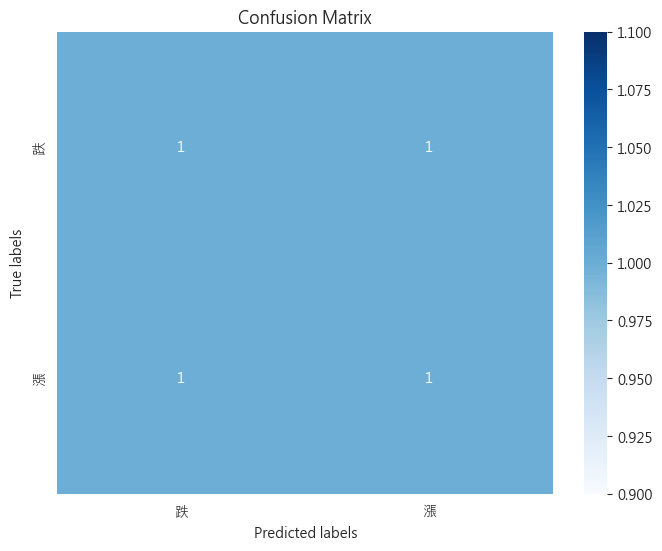

In [219]:
print("出手率: " + str(round(np.mean(take_array), 4) * 100) + "%")
sns.set_style("whitegrid",{"font.sans-serif":['Microsoft JhengHei']})
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["跌", "漲"], yticklabels=["跌", "漲"])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

### 宏碁

In [22]:
stock_name = "宏碁"
stock_symbol = "2353"
merged_df_acer = after_merge_data(stock_name, stock_symbol, n=1, delta1=0.06, delta2=0.02) 
print(merged_df_acer['label'].value_counts())

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_21996\976656221.py:10: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  stock_df = pd.read_csv("./data/bda2024_微股力_個股交易數據-2年.csv")


label
1    1167
0     358
Name: count, dtype: int64


In [23]:
merged_df_acer, vocabulary_acer = get_vocabulary(merged_df_acer)
pd.DataFrame(vocabulary_acer.keys()).to_csv(f"./keywords/{stock_name}_關鍵字列表.csv")
X_acer, y_acer = get_X_y(merged_df_acer, vocabulary_acer)
train_X_acer, test_X_acer, train_y_acer, test_y_acer = train_test_split(X_acer, y_acer, test_size=0.2, random_state=28)

C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_extraction\text.py:1381: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


NN:
10/10 [==============================] - 0s 1ms/step


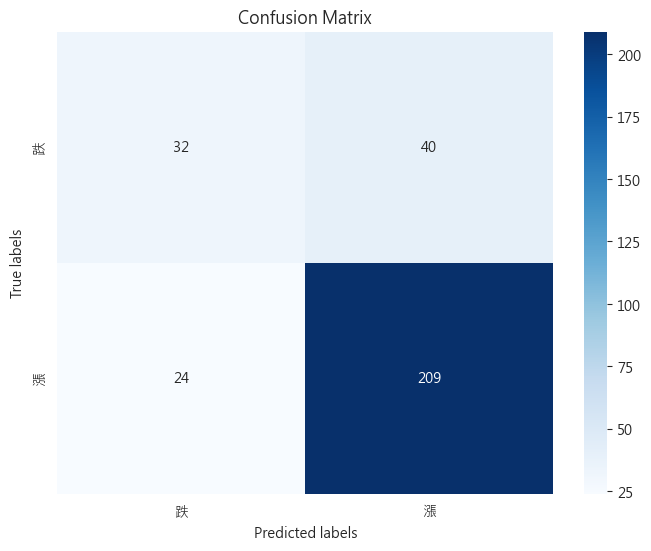

Accuracy: 79.02%

MultinomialNB


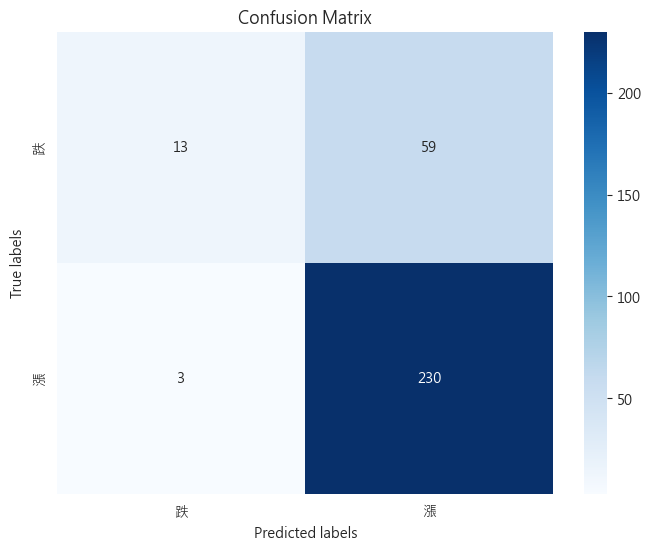

Accuracy: 79.67%

DecisionTreeClassifier


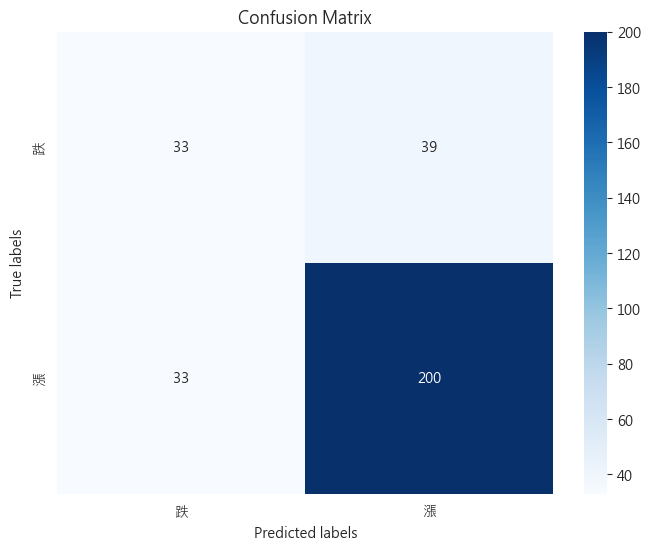

Accuracy: 76.39%

KNeighborsClassifier


C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


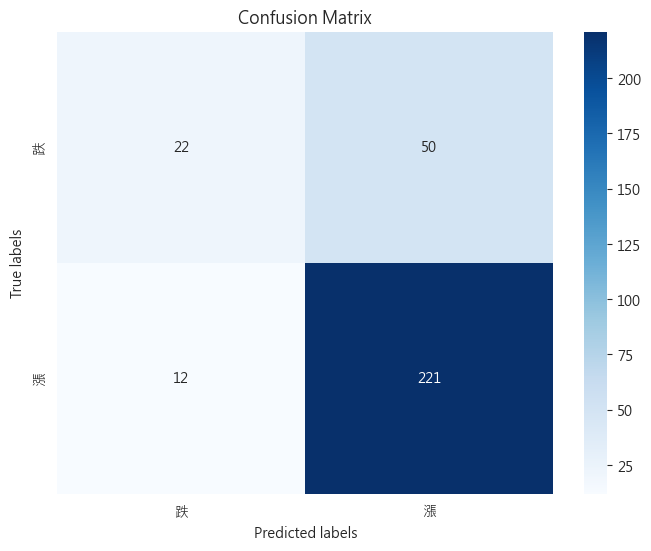

Accuracy: 79.67%

SVC


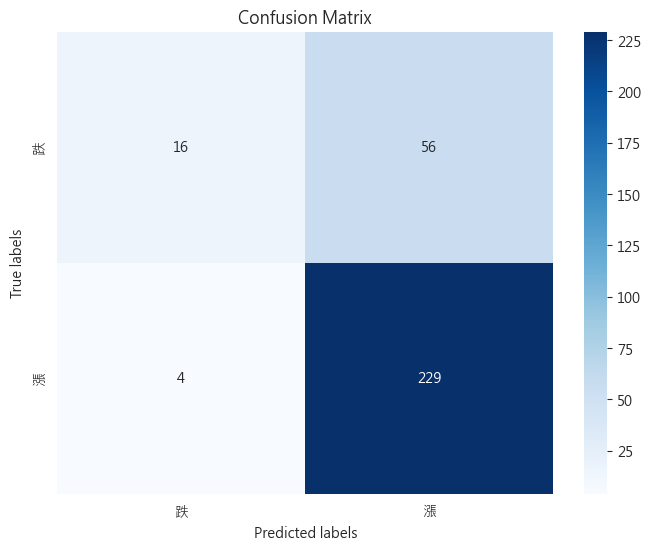

Accuracy: 80.33%

RandomForestClassifier


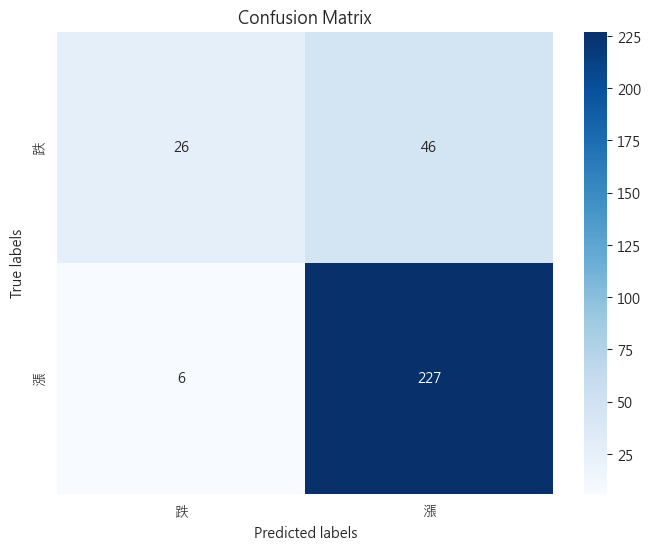

Accuracy: 82.95%



In [27]:
NN_model_acer = build_model((X_acer.shape[1],))
callbacks = [
keras.callbacks.ModelCheckpoint(f"./models/{stock_name}_overall.keras", save_best_only=True)
]

classifier1 = MultinomialNB()
classifier2 = DecisionTreeClassifier()
classifier3 = KNeighborsClassifier(n_neighbors=7)
classifier4 = SVC()
classifier5 = RandomForestClassifier(n_estimators=200)
for model in ["NN", classifier1, classifier2, classifier3, classifier4, classifier5]:
    if model == "NN":
        print("NN:")
        history = NN_model_acer.fit(train_X_acer, train_y_acer, epochs=100, batch_size=32, validation_data=(test_X_acer, test_y_acer), callbacks=callbacks, verbose=0)
        _, acc = NN_model_acer.evaluate(test_X_acer, test_y_acer)
        show_confusion_matrix(test_y_acer, (NN_model_acer.predict(test_X_acer) > 0.5).astype(int))
        print(f"Accuracy: {round(acc, 4) * 100}%\n")
    else:
        print(f"{type(model).__name__}")
        model.fit(train_X_acer, train_y_acer)
        with open(f"./models/{stock_name}_{type(model).__name__}.pkl", 'wb') as file: pickle.dump(model, file)
        show_confusion_matrix(test_y_acer, model.predict(test_X_acer))
        print(f"Accuracy: {round(accuracy_score(test_y_acer, model.predict(test_X_acer)), 4) * 100}%\n")
        

In [28]:
train_dataset = []
test_dataset = []
for i in range(len(date_interval) - 1):
    train_dataset.append(curation(merged_df_acer, date_interval[i][0], date_interval[i][1]))
    test_dataset.append(curation(merged_df_acer, date_interval[i][1], date_interval[i + 1][1]))
history_test = []
pred_y_history = []
y_history = []
accuracy_array = []
take_array = []
conf_matrix = np.array([[0, 0], [0, 0]])
for i in range(len(train_dataset)):
    try:
        train_dataset[i], temp_vocabulary = get_vocabulary(train_dataset[i])
        pd.DataFrame(temp_vocabulary.keys()).to_csv(f"./keywords/{stock_name}_關鍵字列表_{i + 1}.csv")
        temp_X, temp_y = get_X_y(train_dataset[i], temp_vocabulary)
        temp_X_test, temp_y_test = get_X_y(test_dataset[i], temp_vocabulary)
        y_history.append(temp_y_test)
        # temp_model = build_model((temp_X.shape[1],)) ## NN的方式
        temp_model = RandomForestClassifier(200)
        history_test.append(temp_model.fit(temp_X, temp_y))
        # with open(f'./models/{stock_name}_{type(temp_model).__name__}_{i}.pkl', 'wb') as file: pickle.dump(temp_model, file)
        y_pred = temp_model.predict(temp_X_test)
        # y_pred = (y_pred > 0.5).astype(int) # 用NN的方式需要這樣做!! 否則註解掉
        test_dataset[i]["pred"] = y_pred
        counts = test_dataset[i].groupby(["date", "pred"]).size().unstack(fill_value=0)
        counts["pred"] = counts.apply(lambda x: 1 if x.get(1, 0) > x.get(0, 0) else (0 if x.get(0, 0) > x.get(1, 0) else "不買"), axis=1)
        results = counts.merge(test_dataset[i][["date", "label"]].drop_duplicates(), on="date")
        print(results)
        accuracy_array.append((results.pred == results.label).mean())
        take_array.append(((results['pred'] == 1) | (results['pred'] == 0)).mean())
        print(f"準確率: {(results.pred == results.label).mean()}")
        print(f"出手率: {((results['pred'] == 1) | (results['pred'] == 0)).mean()}")
        filtered_results = results[(results['pred'] == 1) | (results['pred'] == 0)]
        conf_matrix += confusion_matrix(filtered_results['label'], filtered_results['pred'], labels=[0, 1])
    except:
        print("")

C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_extraction\text.py:1381: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


        date  1  pred  label
0 2022-06-20  8     1      1
1 2022-06-29  8     1      0
準確率: 0.5
出手率: 1.0


C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_extraction\text.py:1381: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


        date   1  pred  label
0 2022-07-06   7     1      1
1 2022-07-12  10     1      1
準確率: 1.0
出手率: 1.0


C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_extraction\text.py:1381: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


        date   1  pred  label
0 2022-08-05  18     1      1
準確率: 1.0
出手率: 1.0


C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_extraction\text.py:1381: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


        date   1  pred  label
0 2022-09-07  10     1      1
1 2022-09-08  11     1      1
2 2022-09-28   4     1      1
準確率: 1.0
出手率: 1.0


C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_extraction\text.py:1381: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


        date  1  pred  label
0 2022-10-04  7     1      1
1 2022-10-13  8     1      1
準確率: 1.0
出手率: 1.0


C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_extraction\text.py:1381: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


        date   1  pred  label
0 2022-11-04  16     1      1
準確率: 1.0
出手率: 1.0


C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_extraction\text.py:1381: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_extraction\text.py:1381: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(
C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_extraction\text.py:1381: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_extraction\text.py:1381: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


        date   1  pred  label
0 2023-04-10  16     1      1
1 2023-04-27  15     1      1
準確率: 1.0
出手率: 1.0


C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_extraction\text.py:1381: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


        date   1  pred  label
0 2023-05-04  29     1      0
1 2023-05-05  31     1      1
2 2023-05-11  11     1      1
準確率: 0.6666666666666666
出手率: 1.0


C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_extraction\text.py:1381: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


        date  0   1  pred  label
0 2023-06-01  0  22     1      1
1 2023-06-06  2  17     1      1
2 2023-06-07  0  13     1      1
3 2023-06-19  0  28     1      1
4 2023-06-20  0  20     1      1
5 2023-06-27  0  12     1      1
準確率: 1.0
出手率: 1.0


C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_extraction\text.py:1381: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


        date    1  pred  label
0 2023-07-07   20     1      1
1 2023-07-10   17     1      1
2 2023-07-13   13     1      1
3 2023-07-14   16     1      1
4 2023-07-17   28     1      1
5 2023-07-18  101     1      0
6 2023-07-21   37     1      1
準確率: 0.8571428571428571
出手率: 1.0


C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_extraction\text.py:1381: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


        date  0   1  pred  label
0 2023-08-02  1  20     1      1
1 2023-08-04  0  13     1      1
2 2023-08-11  0  15     1      1
3 2023-08-14  3  13     1      1
4 2023-08-15  5   8     1      1
5 2023-08-16  0  20     1      1
6 2023-08-29  1  14     1      1
7 2023-08-31  0   5     1      1
準確率: 1.0
出手率: 1.0


C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_extraction\text.py:1381: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


        date   1  pred  label
0 2023-09-01  10     1      1
1 2023-09-11  14     1      1
2 2023-09-28  20     1      1
準確率: 1.0
出手率: 1.0


C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_extraction\text.py:1381: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


        date   1  pred  label
0 2023-10-04  11     1      1
1 2023-10-11  13     1      1
準確率: 1.0
出手率: 1.0


C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_extraction\text.py:1381: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


        date   1  pred  label
0 2023-11-10  27     1      1
1 2023-11-13   9     1      1
2 2023-11-17  26     1      1
準確率: 1.0
出手率: 1.0


C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_extraction\text.py:1381: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


        date   1  pred  label
0 2023-12-08  17     1      1
1 2023-12-14  10     1      1
2 2023-12-15  15     1      1
3 2023-12-18  33     1      1
4 2023-12-19  39     1      0
5 2023-12-20  65     1      0
6 2023-12-22  23     1      1
7 2023-12-25  50     1      1
8 2023-12-26  53     1      1
9 2023-12-29  73     1      0
準確率: 0.7
出手率: 1.0


C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_extraction\text.py:1381: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


        date   0   1  pred  label
0 2024-01-02  14  29     1      0
1 2024-01-03   0  13     1      1
2 2024-01-16   3  10     1      1
3 2024-01-18   4  19     1      1
4 2024-01-19   4  16     1      1
5 2024-01-26   5  17     1      1
6 2024-01-31   2  10     1      1
準確率: 0.8571428571428571
出手率: 1.0


C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_extraction\text.py:1381: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


        date   0   1  pred  label
0 2024-02-05   9  49     1      1
1 2024-02-26  10  32     1      1
準確率: 1.0
出手率: 1.0


Average test accuracy:  91.65%


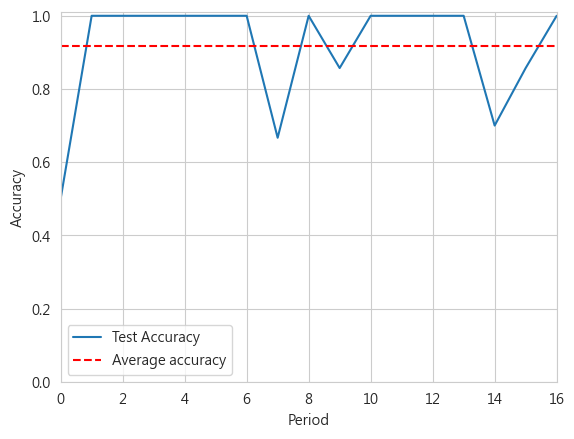

In [25]:
print(f"Average test accuracy:  {100 * np.mean(accuracy_array):.2f}%")
epoch = range(len(history_test))
plt.figure()
plt.xlabel('Period')
plt.ylabel('Accuracy')
plt.plot(epoch, accuracy_array, label='Test Accuracy')
plt.plot(epoch, [np.mean(accuracy_array) for _ in epoch], "r--", label="Average accuracy")
plt.xlim([0, len(history_test) - 1])
plt.ylim([0, 1.01])
plt.legend()

出手率: 100.0%


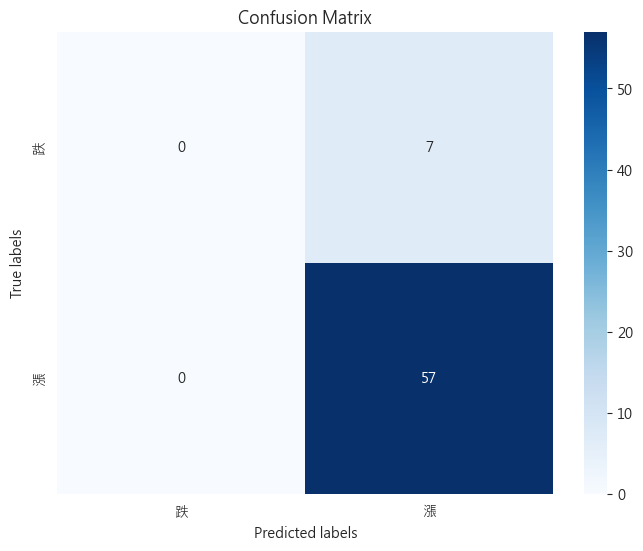

In [26]:
print("出手率: " + str(round(np.mean(take_array), 4) * 100) + "%")
sns.set_style("whitegrid",{"font.sans-serif":['Microsoft JhengHei']})
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["跌", "漲"], yticklabels=["跌", "漲"])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

- 台積電

In [24]:
stock_name = "台積電"
stock_symbol = "2330"
merged_df_tsmc = after_merge_data(stock_name, stock_symbol, n=1, delta1=0.06, delta2=0.03)
print(merged_df_tsmc['label'].value_counts())

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_23480\976656221.py:10: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  stock_df = pd.read_csv("./data/bda2024_微股力_個股交易數據-2年.csv")


label
1    4149
0     553
Name: count, dtype: int64


In [25]:
merged_df_tsmc, vocabulary_tsmc = get_vocabulary(merged_df_tsmc)
pd.DataFrame(vocabulary_tsmc.keys()).to_csv(f"./keywords/{stock_name}_關鍵字列表.csv")
X_tsmc, y_tsmc = get_X_y(merged_df_tsmc, vocabulary_tsmc)
train_X_tsmc, test_X_tsmc, train_y_tsmc, test_y_tsmc = train_test_split(X_tsmc, y_tsmc, test_size=0.2, random_state=28)
NN_model_tsmc = build_model((X_tsmc.shape[1],))
callbacks = [
keras.callbacks.ModelCheckpoint(f"./models/{stock_name}_overall.keras", save_best_only=True)
]

C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_extraction\text.py:1381: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


NN:
30/30 [==============================] - 0s 2ms/step


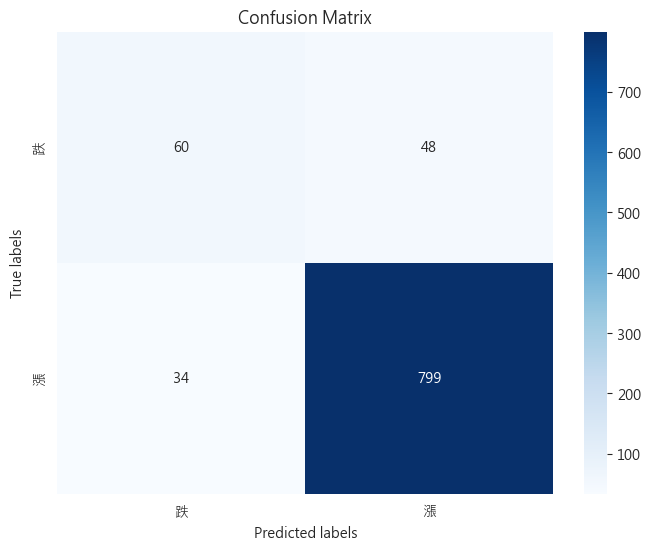

Accuracy: 91.29%

MultinomialNB


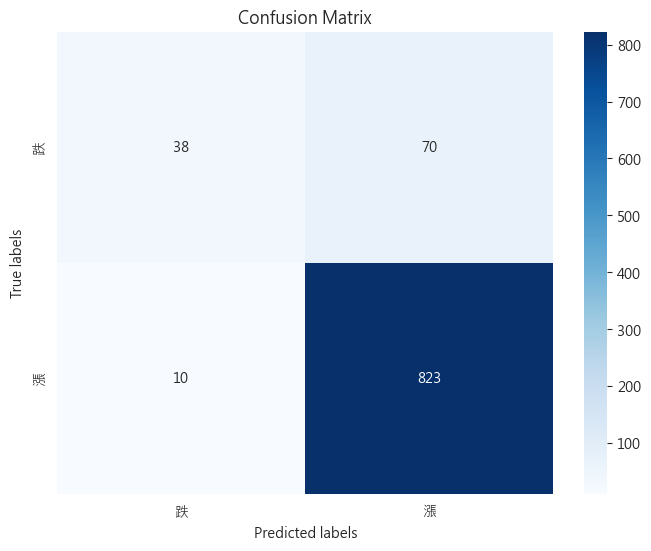

Accuracy: 91.5%

DecisionTreeClassifier


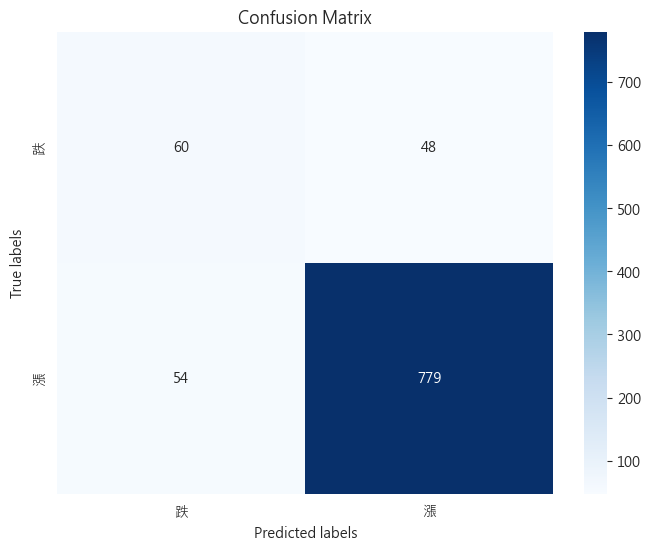

Accuracy: 89.16%

KNeighborsClassifier


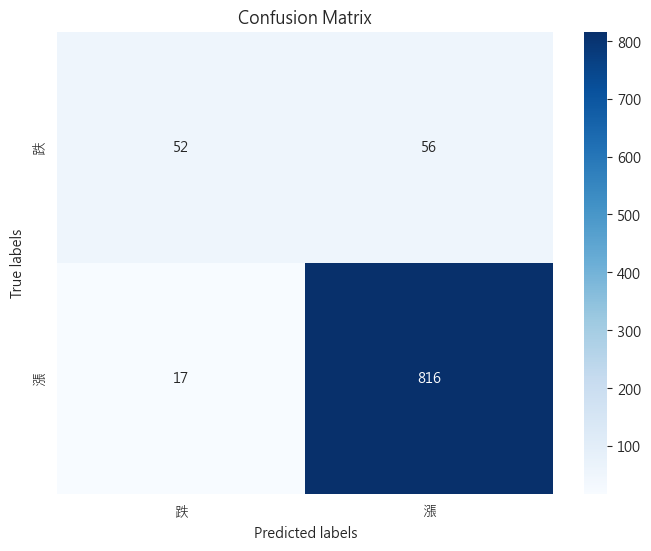

Accuracy: 92.24%

SVC


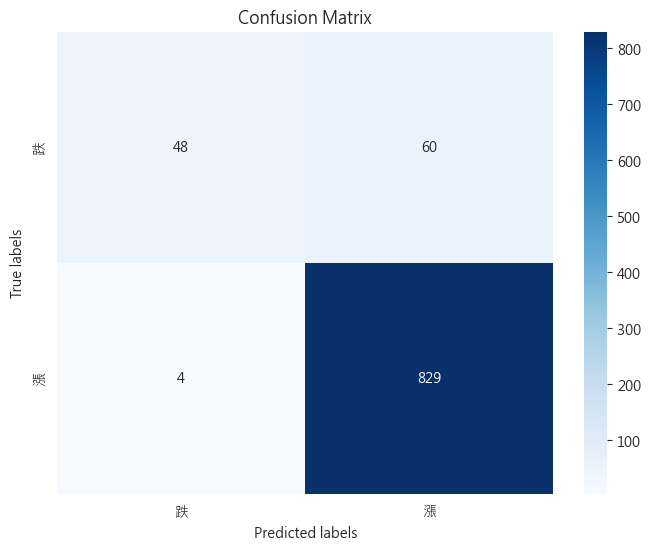

Accuracy: 93.2%

RandomForestClassifier


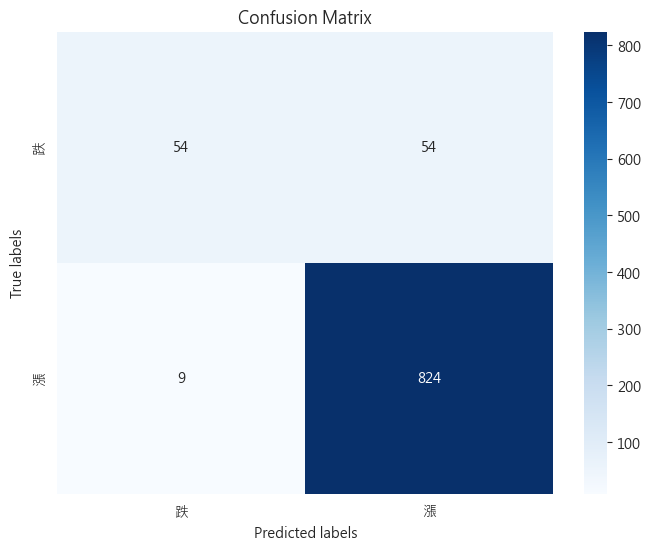

Accuracy: 93.30000000000001%



In [30]:
classifier1 = MultinomialNB()
classifier2 = DecisionTreeClassifier()
classifier3 = KNeighborsClassifier(n_neighbors=7)
classifier4 = SVC()
classifier5 = RandomForestClassifier(n_estimators=200)
for model in ["NN", classifier1, classifier2, classifier3, classifier4, classifier5]:
    if model == "NN":
        print("NN:")
        history = NN_model_tsmc.fit(train_X_tsmc, train_y_tsmc, epochs=10, batch_size=32, validation_data=(test_X_tsmc, test_y_tsmc), callbacks=callbacks, verbose=0)
        _, acc = NN_model_tsmc.evaluate(test_X_tsmc, test_y_tsmc)
        show_confusion_matrix(test_y_tsmc, (NN_model_tsmc.predict(test_X_tsmc) > 0.5).astype(int))
        print(f"Accuracy: {round(acc, 4) * 100}%\n")
    else:
        print(f"{type(model).__name__}")
        model.fit(train_X_tsmc, train_y_tsmc)
        with open(f"./models/{stock_name}_{type(model).__name__}.pkl", 'wb') as file: pickle.dump(model, file)
        show_confusion_matrix(test_y_tsmc, model.predict(test_X_tsmc))
        print(f"Accuracy: {round(accuracy_score(test_y_tsmc, model.predict(test_X_tsmc)), 4) * 100}%\n")
        

In [27]:
train_dataset = []
test_dataset = []
for i in range(len(date_interval) - 1):
    train_dataset.append(curation(merged_df_tsmc, date_interval[i][0], date_interval[i][1]))
    test_dataset.append(curation(merged_df_tsmc, date_interval[i][1], date_interval[i + 1][1]))
history_test = []
pred_y_history = []
y_history = []
accuracy_array = []
take_array = []
conf_matrix = np.array([[0, 0], [0, 0]])
for i in range(len(train_dataset)):
    try:
        train_dataset[i], temp_vocabulary = get_vocabulary(train_dataset[i])
        pd.DataFrame(temp_vocabulary.keys()).to_csv(f"./keywords/{stock_name}_關鍵字列表_{i + 1}.csv")
        temp_X, temp_y = get_X_y(train_dataset[i], temp_vocabulary)
        temp_X_test, temp_y_test = get_X_y(test_dataset[i], temp_vocabulary)
        y_history.append(temp_y_test)
        # temp_model = build_model((temp_X.shape[1],)) ## NN的方式
        temp_model = RandomForestClassifier(n_estimators=200)
        history_test.append(temp_model.fit(temp_X, temp_y))
        # with open(f'./models/{stock_name}_{type(temp_model).__name__}_{i}.pkl', 'wb') as file: pickle.dump(temp_model, file)
        y_pred = temp_model.predict(temp_X_test)
        # y_pred = (y_pred > 0.5).astype(int) # 用NN的方式需要這樣做!! 否則註解掉
        test_dataset[i]["pred"] = y_pred
        counts = test_dataset[i].groupby(["date", "pred"]).size().unstack(fill_value=0)
        counts["pred"] = counts.apply(lambda x: 1 if x.get(1, 0) > (x.get(0, 0) + 5) else (0 if x.get(0, 0) > x.get(1, 0 + 5) else "不買"), axis=1)
        results = counts.merge(test_dataset[i][["date", "label"]].drop_duplicates(), on="date")
        print(results)
        accuracy_array.append((results.pred == results.label).mean())
        take_array.append(((results['pred'] == 1) | (results['pred'] == 0)).mean())
        print(f"準確率: {(results.pred == results.label).mean()}")
        print(f"出手率: {((results['pred'] == 1) | (results['pred'] == 0)).mean()}")
        filtered_results = results[(results['pred'] == 1) | (results['pred'] == 0)]
        conf_matrix += confusion_matrix(filtered_results['label'], filtered_results['pred'])
    except:
        print("")

C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_extraction\text.py:1381: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_extraction\text.py:1381: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


        date    1  pred  label
0 2022-07-06  193     1      1
1 2022-07-12  118     1      1
2 2022-07-14  184     1      1
準確率: 1.0
出手率: 1.0


C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_extraction\text.py:1381: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


        date    1  pred  label
0 2022-08-04  115     1      1
準確率: 1.0
出手率: 1.0


C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_extraction\text.py:1381: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_extraction\text.py:1381: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


        date    1  pred  label
0 2022-10-04   79     1      1
1 2022-10-07  553     1      0
2 2022-10-13  348     1      1
準確率: 0.6666666666666666
出手率: 1.0


C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_extraction\text.py:1381: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


        date   0   1  pred  label
0 2022-11-08  19  91     1      1
1 2022-11-10  11  97     1      1
2 2022-11-14   5  53     1      1
準確率: 1.0
出手率: 1.0


C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_extraction\text.py:1381: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_extraction\text.py:1381: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


        date   0    1  pred  label
0 2023-01-06  31   93     1      1
1 2023-01-17  32  325     1      1
準確率: 1.0
出手率: 1.0


C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_extraction\text.py:1381: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


        date   1  pred  label
0 2023-02-07  63     1      1
準確率: 1.0
出手率: 1.0


C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_extraction\text.py:1381: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


        date   1  pred  label
0 2023-03-21  66     1      1
準確率: 1.0
出手率: 1.0


C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_extraction\text.py:1381: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_extraction\text.py:1381: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


        date    1  pred  label
0 2023-05-24   72     1      1
1 2023-05-25  127     1      1
準確率: 1.0
出手率: 1.0


C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_extraction\text.py:1381: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


        date   1  pred  label
0 2023-06-12  61     1      1
準確率: 1.0
出手率: 1.0


C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_extraction\text.py:1381: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_extraction\text.py:1381: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


        date    1  pred  label
0 2023-08-25  165     1      1
準確率: 1.0
出手率: 1.0


C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_extraction\text.py:1381: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_extraction\text.py:1381: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


        date    1  pred  label
0 2023-10-04   89     1      1
1 2023-10-06  130     1      1
準確率: 1.0
出手率: 1.0


C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_extraction\text.py:1381: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


        date    1  pred  label
0 2023-11-01   66     1      1
1 2023-11-10  258     1      1
準確率: 1.0
出手率: 1.0


C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_extraction\text.py:1381: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_extraction\text.py:1381: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


        date    1  pred  label
0 2024-01-18  164     1      1
準確率: 1.0
出手率: 1.0


C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_extraction\text.py:1381: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


        date    1  pred  label
0 2024-02-05  515     1      1
準確率: 1.0
出手率: 1.0


Average test accuracy:  97.62%


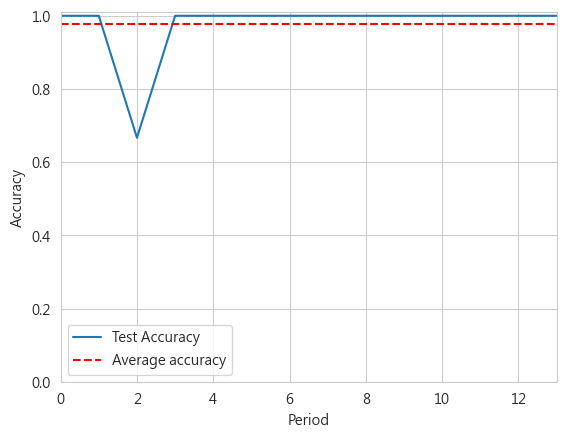

In [28]:
print(f"Average test accuracy:  {100 * np.mean(accuracy_array):.2f}%")
epoch = range(len(history_test))
plt.figure()
plt.xlabel('Period')
plt.ylabel('Accuracy')
plt.plot(epoch, accuracy_array, label='Test Accuracy')
plt.plot(epoch, [np.mean(accuracy_array) for _ in epoch], "r--", label="Average accuracy")
plt.xlim([0, len(history_test) - 1])
plt.ylim([0, 1.01])
plt.legend()

出手率: 100.0%


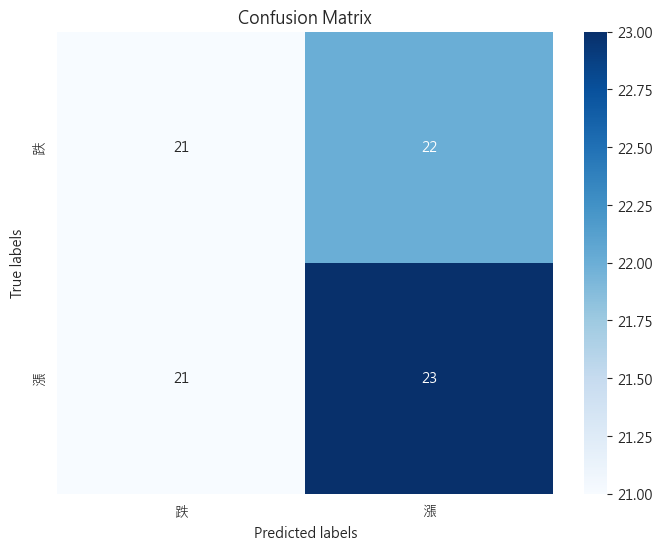

In [29]:
print("出手率: " + str(round(np.mean(take_array), 4) * 100) + "%")
sns.set_style("whitegrid",{"font.sans-serif":['Microsoft JhengHei']})
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["跌", "漲"], yticklabels=["跌", "漲"])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()